In [1]:
import subprocess
import numpy as np
import simplifier
import csv
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib as mpl
import sympy
import sys
from scipy.optimize import minimize
rc('text', usetex=True)
rc('axes', titlesize=12, labelsize=12)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)

sys.path.insert(0, 'Pantheon/')
import likelihood_panth
import test_all
from filenames import *
from symbols_panth import *

# Figure 3 - Pantheon Data Comparsion

In [2]:
print('Loading data')
xvar, yvar, inv_cov, yerr = likelihood_panth.load_data()
xvar += 1  # now x = 1 + z
print('Loaded')

Loading data
Loaded


	 0 10
	 1 10
	 2 10
	 3 10
	 4 10
701.8518992970024 [0.39043107 0.79050758 0.         0.        ]
0.0 6.373363093873309
1 of 100: a0 + pow(x,x)
2 of 100: pow(Abs(a0 + x),x)
3 of 100: x*pow(Abs(a0),(x**2))
4 of 100: pow(Abs(a0 + x),(pow(x,a1)))
5 of 100: a0*pow(x,x)
6 of 100: a0 + pow(x,(pow(Abs(a1),x)))
7 of 100: a0*x + pow(x,x)
8 of 100: pow((x*Abs(a0)),(pow(x,a1)))
9 of 100: a0 + pow(x,(a1 + x))
10 of 100: pow((x + pow(x,a0)),a1)
11 of 100: pow(Abs(a0 - x),(pow(Abs(a1),x)))
12 of 100: a0/pow(Abs(a1),x)
13 of 100: a0*pow(x,(pow(x,a1)))
14 of 100: pow(Abs(a0),(pow(Abs(a1),(1/x))))
15 of 100: pow(x,x) + 1/a0
16 of 100: pow(x,a0) + pow(Abs(a1),x)
17 of 100: pow(Abs(a0),(pow(Abs(a1),(pow(x,a2)))))
18 of 100: pow(Abs(x - 1/a0),x)
19 of 100: pow(Abs(a0 + x),a1)
20 of 100: x + pow(Abs(a0),(a1 + x))
21 of 100: x + pow(Abs(a0 - x),x)
22 of 100: a0 + pow(Abs(a1 + x),x)
23 of 100: x*pow(Abs(a0),(pow(x,x)))
24 of 100: pow((x + pow(Abs(a0),x)),a1)
25 of 100: pow(Abs(a0 + pow(x,a1)),x)
26 of 100: 

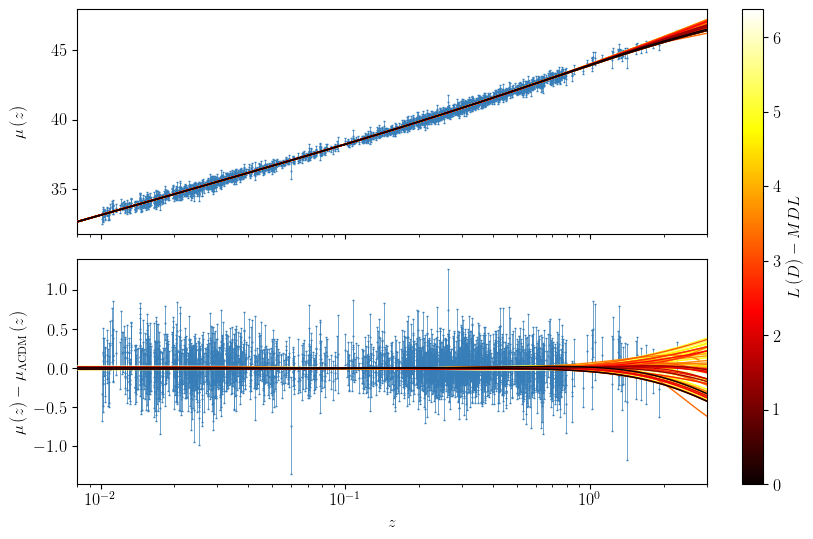

In [5]:
xplot = np.logspace(np.log10(8e-3), np.log10(3), 1000) + 1
tmax = 5

# GET LCDM FUNCTION
fcn_i = 'a0 * pow(x, 3) + a1'
fcn_i, eq, integrated = run_sympify(fcn_i, tmax=tmax, try_integration=False)

if 'a3' in fcn_i:
    k = 4
    eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy","sympy"])
elif 'a2' in fcn_i:
    k = 3
    eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy","sympy"])
elif 'a1' in fcn_i:
    k = 2
    eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy","sympy"])
elif 'a0' in fcn_i:
    k = 1
    eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy","sympy"])
else:
    k = 0
    eq_numpy = sympy.lambdify([x], eq, modules=["numpy","sympy"])

likelihood_panth.data_x = None
likelihood_panth.data_mask = None
chi2, p = test_all.optimise_fun(fcn_i, xvar, yvar, inv_cov, tmax, 0, 4, try_integration=False)
print(chi2, p)

likelihood_panth.data_x = None
likelihood_panth.data_mask = None
ylcdm_var = likelihood_panth.get_pred(xvar, p[:k], eq_numpy, integrated=integrated)

likelihood_panth.data_x = None
likelihood_panth.data_mask = None
ylcdm_plot = likelihood_panth.get_pred(xplot, p[:k], eq_numpy, integrated=integrated)

likelihood_panth.data_x = None
likelihood_panth.data_mask = None

# GET OTHER FUNCTIONS
all_compl = np.arange(3, 9)
# all_compl = [3, 4, 5]
# all_compl = [7]
fcn_list = []
all_DL = []
params = []

for i, compl in enumerate(all_compl):
    fname = out_dir + '/final_%i.dat'%compl
    with open(fname, "r") as f:
        reader = csv.reader(f, delimiter=';')
        data = [row for row in reader]
    fcn_list += [d[1] for d in data]
    all_DL += [d[2] for d in data]
    params += [d[7:] for d in data]
    
all_DL = np.array(all_DL, dtype=float)
params = np.array(params, dtype=float)
m = np.isfinite(all_DL)
all_DL = all_DL[m]
params = params[m,:]
fcn_list = [fcn_list[i] for i in range(len(fcn_list)) if m[i]]
MDL = np.amin(all_DL)

# plt.semilogx(np.sort(all_DL - MDL), np.arange(len(all_DL)))

# Take top 50 functions
nfun = 100
# nfun = 30
idx = np.argsort(all_DL)[:min(nfun, len(all_DL))]
all_DL = all_DL[idx] - MDL
params = params[idx,:]
fcn_list = [fcn_list[i] for i in idx]

fig  = plt.figure(figsize=(7,5))
ax1  = fig.add_axes([0.0,0.50,0.9,0.45])
ax2  = fig.add_axes([0.0,0.0,0.9,0.45])
ax3  = fig.add_axes([0.95,0.00,0.03,0.95])
ax1.get_shared_x_axes().join(ax1, ax2)

cmap = cm.hot
vmin = all_DL.min()
vmax = all_DL.max()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
print(vmin, vmax)

max_param = 4
tmax = 5

likelihood_panth.data_x = None
likelihood_panth.data_mask = None
for i in range(len(fcn_list)):
    
    fcn_i = fcn_list[i].replace('\'', '')

    k = simplifier.count_params([fcn_i], max_param)[0]
    measured = params[i,:k]

    print('%i of %i:'%(i+1,len(fcn_list)), fcn_i)

    try:
        fcn_i, eq, integrated = run_sympify(fcn_i, tmax=tmax)
        if k == 0:
            eq_numpy = sympy.lambdify([x], eq, modules=["numpy","sympy"])
        elif k==1:
            eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy","sympy"])
        elif k==2:
            eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy","sympy"])
        elif k==3:
            eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy","sympy"])
        elif k==4:
            eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy","sympy"])
        ypred_plot = likelihood_panth.get_pred(xplot, measured, eq_numpy, integrated=integrated)
    except:
        fcn_i, eq, integrated = run_sympify(fcn_i, tmax=tmax, try_integration=False)
        if k == 0:
            eq_numpy = sympy.lambdify([x], eq, modules=["numpy","sympy"])
        elif k==1:
            eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy","sympy"])
        elif k==2:
            eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy","sympy"])
        elif k==3:
            eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy","sympy"])
        elif k==4:
            eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy","sympy"])
        ypred_plot = likelihood_panth.get_pred(xplot, measured, eq_numpy, integrated=integrated)
        
    colour = cmap(norm(all_DL[i]))
    plot_kwargs = {'color':colour, 'zorder':len(fcn_list)-i, 'lw':1}

    ax1.plot(xplot-1, ypred_plot, **plot_kwargs)
    ax2.plot(xplot-1, ypred_plot-ylcdm_plot, **plot_kwargs)
            
cmvar = plt.get_cmap('Set1')
plot_kwargs = {'fmt':'.', 'markersize':1, 'zorder':-1, 
             'capsize':1, 'elinewidth':0.5, 'color':cmvar(1), 'alpha':1}
# 'zorder':len(fcn_list)+1

ax1.errorbar(xvar-1, yvar, yerr=yerr, **plot_kwargs)
ax2.errorbar(xvar-1, yvar-ylcdm_var, yerr=yerr, **plot_kwargs)
ax2.axhline(y=0, color=cmvar(1), ls='--')

ax2.set_xlabel(r'$z$')
ax1.set_ylabel(r'$\mu \left( z \right)$')
ax2.set_ylabel(r'$\mu \left( z \right) - \mu_{\rm \Lambda CDM} \left( z \right)$')

ax1.set_xlim(xplot.min()-1, xplot.max()-1)
ax1.set_xscale('log')
ax1.set_xticklabels([])

cb1 = mpl.colorbar.ColorbarBase(ax3,cmap=cmap,norm=norm,orientation='vertical')
cb1.set_label(r'$L \left( D \right) - MDL$')

fig.align_ylabels([ax1, ax2])
fig.tight_layout()

ax1.get_yaxis().set_label_coords(-0.08,0.5)
ax2.get_yaxis().set_label_coords(-0.08,0.5)

fig.savefig('figs/pantheon_prediction.pdf', bbox_inches='tight', transparent=True)

# MAKE THESE GOOD

In [ ]:
ll = []
for compl in range(3, 9):
    fname = dirname + 'final_%i.dat'%compl
    with open(fname, "r") as f:
        reader = csv.reader(f, delimiter=';')
        data = [row for row in reader]
        ll += [d[4] for d in data]
ll = np.array(ll, dtype=float)
ll = ll[np.isfinite(ll)]
min_ll = np.amin(ll)
ll = ll[ll<5+min_ll]
plt.hist(ll, bins=30, histtype='step')
plt.axvline(lcdm_chi2, color='k', label=r'$\LambdaCDM$')
plt.xlabel(r'$- \log \mathcal{L}$')
plt.tight_layout()
print(min_ll)
nbetter = np.sum(ll < lcdm_chi2)
print('Number better than LCDM (logL):', nbetter)